Ref: https://byt3bit.github.io/primesym/mimc/

MiMC is a block cipher and hash function family designed specifically for SNARK applications. The low multiplicative complexity of MiMC over prime fields makes it suitable for ZK-SNARK applications such as ZCash.

he core component of MiMC is the APN function $f(x)=x^3$. The function is computed in $\mathbb{F}_q$, where $q=p$ or $q=2^n$ for a prime number $p$ and a natural number $n$.

The key scheduling adds the same (uniformly randomly chosen secret) key $k\in \mathbb{F}_q$ at each round and is followed by the round constant addition. In detail, the encryption function of MiMC is


$$
E_k(x) = (F_{r-1} \circ F_{r-2} \circ \cdots \circ F_0)(x) + k
$$

where $x\in \mathbb{F}_q$ is the plaintext, $r$ is the number of rounds, $F_i$ is the round function for round $i≥0$, and $k\in \mathbb{F}_q$ is the key. Each $F_i$ is defined as:

$$
F_i(x)=(x+k+c_i)^3
$$

In [1]:
F = lambda x, k, c: (x + k + c)**3

where $c_i \in \mathbb{F}_q$ are the round constants and $c_0=0$. The round constants are chosen as random elements of $𝔽_q$ at the instantiation of MiMC and then fixed. 

Note that there are no round keys, instead the same key is used in each round and once at the end. All the operations are defined in the underlying field $\mathbb{F}_q$.

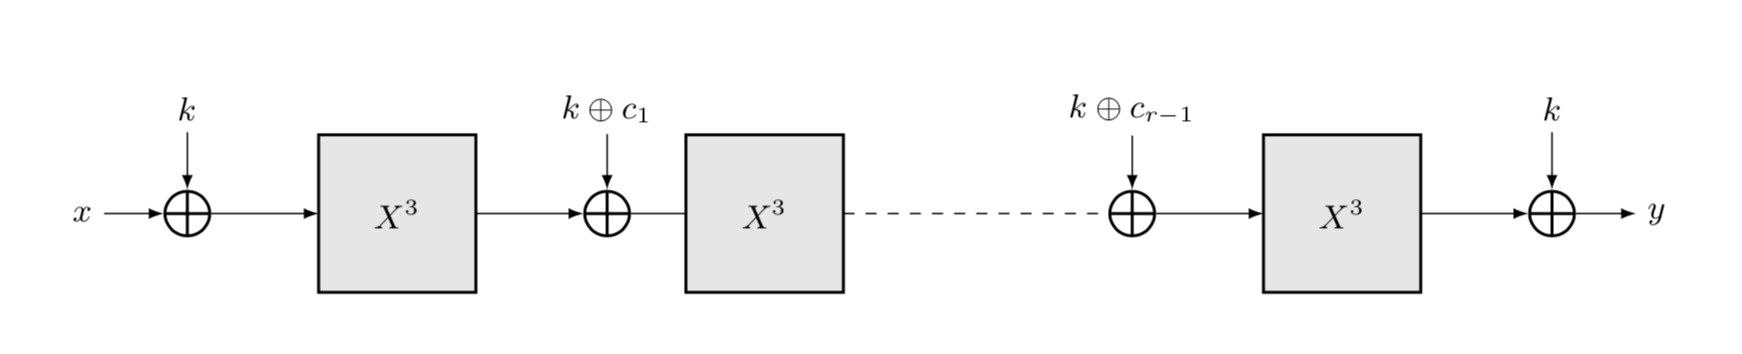

In [2]:
from IPython.display import Image
Image("https://byt3bit.github.io/primesym/mimc/mimc.png", width=800, height=300)

In [3]:
from zkp_playground.curves.baby_jubjub import FiniteFieldBabyJubjub as F
from zkp_playground.types.algebra.utils import randfield
from zkp_playground.utils import to_sha256int
from functools import partial, reduce
from itertools import count
import time
from hashlib import sha256

class MiMC:
    
    @staticmethod
    def F(x, k, c):
        return (x + k + c) ** 3
    
    def __init__(self, field, r):
        self.field = field
        self.c = [field(0)] + [randfield(field) for i in range(1, r)]
        self.r = r
        
    def encrypt(self, x, k, r=None):
        if not r: r = self.r
        Fs = [partial(self.F, k=k, c=c) for c in self.c[:r]]
        return reduce(lambda x, y: x + y(x), Fs[1:], Fs[0](x)) + k

    def E(self, *args, **kwargs):
        return self.encrypt(*args, **kwargs)


        
        
            

In [4]:
MiMC(F, 10).E(F(42), F(3))

FiniteFieldBabyJubjub::2885821964811861859932701060726602131431756132593464134611333499114301796348

For a 2n-bit key, $(K_0,K_1)$ $\in \mathbb{F}_q^2$ is chosen uniformly randomly. In this case the two keys $K_0$ and $K_1$ are added alternately through the rounds. Hence, the key scheduling for round $i$ is defined as $k_i=K_{i(mod2)}$, and the round function is defined as:

$$
F_i(x)=(x+k_i+c_i)^3
$$

for $i\ge0$

Feistel-MiMC is constructed over $\mathbb{F}_q$ using the same round function $f(x)=x^3$. Note that in Feistel-MiMC the input (and output) is in $\mathbb{F_q^2}. Each round of is defined as

$$
(x_{i+1},y_{i+1})=(y_i,x_i+(y_i+k_i+c_i)^3)
$$

where $(x_{i+1},y_{i+1})$ is the state after round $i$, $(x_0,y_0)$ is the input and $k_i=(i+1)⋅k$ for $i≥0$.

In [5]:
class FeistelMiMC:
    
    @staticmethod
    def F(x, y, k, c):
        return (y, x + (y + k + c) ** 3)
    
    def __init__(self, field, r):
        self.field = field
        self.c = [field(0)] + [randfield(field) for i in range(1, r)]
        self.r = r
        
    def encrypt(self, x, y, k, r=None):
        if not r: r = self.r
        Ks = [(i + self.field(1)) * k for i in range(0, r)]
        Fs = [partial(self.F, k=k, c=c) for (k, c) in zip(Ks[:r], self.c[:r])]
        return reduce(
            lambda x, y: y(*x), Fs[1:], Fs[0](x, y)
        )

    def E(self, *args, **kwargs):
        return self.encrypt(*args, **kwargs)


In [6]:
FeistelMiMC(F, 10).E(F(42), F(24), F(3))

(FiniteFieldBabyJubjub::8665853564593005456130595214612681020395686976966229934484269532609289268166,
 FiniteFieldBabyJubjub::20128495965523654740184436997877341714032819586887300344794759581243138031844)

In [1]:
SECP256K1_P = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEFFFFFC2F


In [2]:
import zkp_playground.const as C

In [4]:
import math

def to_u32s(a: int, endian="little"):
    l = math.ceil(a.bit_length() / 8)
    def split():
        carry = a
        while carry != 0:
            yield carry % 2**32
            carry = carry // (2 ** 32)

    
    return {
        "big": list(split())[::-1],
        "little": list(split())
    }[endian]

def from_u32s(a: list, endian="little"):
    ret = 0
    pos = 0
    if endian == "big":
        a = a[::-1]
    for i in a:
        ret += i * (2**(32*pos))
        pos += 1
    return ret